In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

In [34]:


transform = transforms.ToTensor()

# Download and load the MNIST training data
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

selected_label = 9

# Filter the dataset to include only images with label normal and 5
label_normal_indices = [i for i, (_, label) in enumerate(train_data) if label == selected_label]
label_anomalie_indices = [i for i, (_, label) in enumerate(train_data) if label != selected_label]
label_normal_indices_test = [i for i, (_, label) in enumerate(test_data) if label == selected_label]
label_anomalie_indices_test = [i for i, (_, label) in enumerate(test_data) if label != selected_label]

# Calculate the number of samples for each label based on the desired proportions
p = 0.25

num_label_normal =  len(label_normal_indices)
num_label_anomalie = int((num_label_normal/(1-p))-num_label_normal)

print(num_label_normal, num_label_anomalie, num_label_normal + num_label_anomalie)

selected_label_anomalie_indices = np.random.choice(label_anomalie_indices, num_label_anomalie, replace=False)

# Combine the selected indices
selected_indices_train = np.concatenate([label_normal_indices, selected_label_anomalie_indices])
selected_indices_test = np.concatenate([label_normal_indices_test, label_anomalie_indices_test])

# Create a Subset of the original dataset with the selected indices
filtered_dataset = torch.utils.data.Subset(train_data, selected_indices_train)
filtered_dataset_test = torch.utils.data.Subset(test_data, selected_indices_test)

print("Len Train:", len(filtered_dataset))
print("Len Test:", len(filtered_dataset_test))

# Create a DataLoader to iterate through the filtered dataset
batch_size = 64
train_loader = torch.utils.data.DataLoader(filtered_dataset, batch_size=batch_size, shuffle=True)
train_loader_without_batch = torch.utils.data.DataLoader(filtered_dataset, shuffle=True)
test_loader = torch.utils.data.DataLoader(filtered_dataset_test, shuffle=True)

5949 1983 7932
Len Train: 7932
Len Test: 10000


In [35]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


In [36]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()        
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7) # -> N, 64, 1, 1
        )
        
        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
 
# Note: nn.MaxPool2d -> use nn.MaxUnpool2d, or use different kernelsize, stride etc to compensate...
# Input [-1, +1] -> use nn.Tanh

In [37]:
model = Autoencoder()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-4, 
                             weight_decay=1e-5)

# Point to training loop video
num_epochs = 30
outputs = []
losses = []
for epoch in range(num_epochs):
    imgs = []
    for (img, _) in train_loader:
        recon = model(img)
        loss = criterion(recon, img)
        imgs.append((img, loss))

    imgs.sort(key=lambda x: x[1])
    l = int(0.5 * len(imgs))
    imgs = imgs[:l]

    optimizer.zero_grad()

    for (img, _) in imgs:
        recon = model(img)
        loss = criterion(recon, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    losses.append(loss)
    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

Epoch:1, Loss:0.1604
Epoch:2, Loss:0.0728
Epoch:3, Loss:0.0614
Epoch:4, Loss:0.0587
Epoch:5, Loss:0.0579
Epoch:6, Loss:0.0579
Epoch:7, Loss:0.0577
Epoch:8, Loss:0.0571
Epoch:9, Loss:0.0569
Epoch:10, Loss:0.0568
Epoch:11, Loss:0.0562
Epoch:12, Loss:0.0558
Epoch:13, Loss:0.0545
Epoch:14, Loss:0.0523
Epoch:15, Loss:0.0496
Epoch:16, Loss:0.0471
Epoch:17, Loss:0.0448
Epoch:18, Loss:0.0425
Epoch:19, Loss:0.0402
Epoch:20, Loss:0.0376
Epoch:21, Loss:0.0349
Epoch:22, Loss:0.0333
Epoch:23, Loss:0.0316
Epoch:24, Loss:0.0294
Epoch:25, Loss:0.0278
Epoch:26, Loss:0.0266
Epoch:27, Loss:0.0250
Epoch:28, Loss:0.0240
Epoch:29, Loss:0.0230
Epoch:30, Loss:0.0220


Epoch: 0
Epoch: 2
Epoch: 4
Epoch: 6
Epoch: 8
Epoch: 10
Epoch: 12
Epoch: 14
Epoch: 16
Epoch: 18
Epoch: 20
Epoch: 22
Epoch: 24
Epoch: 26
Epoch: 28


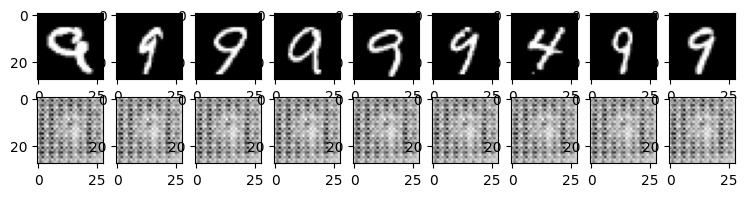

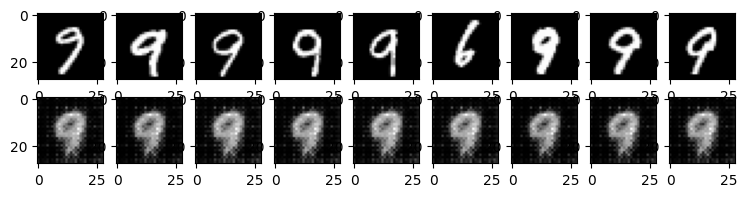

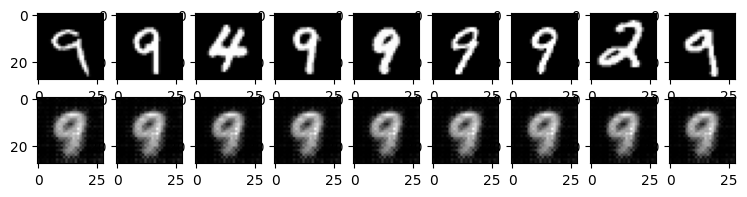

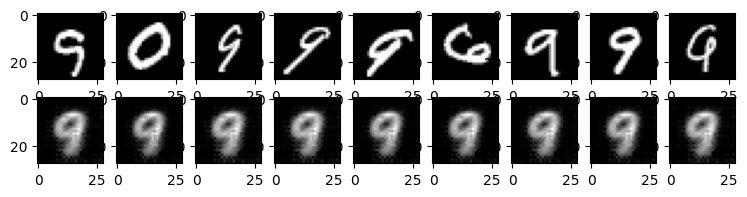

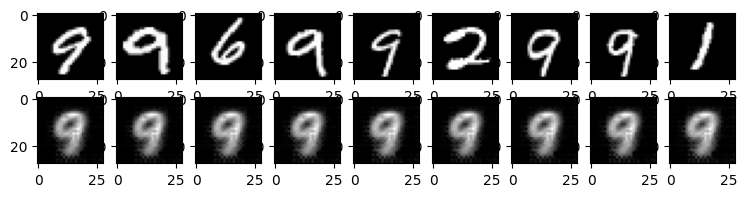

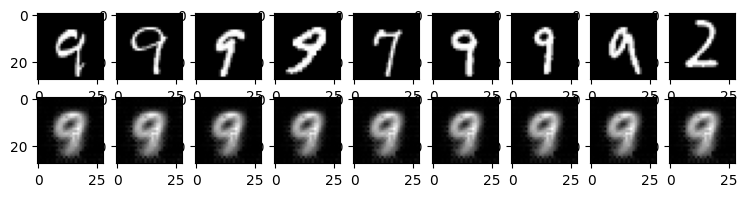

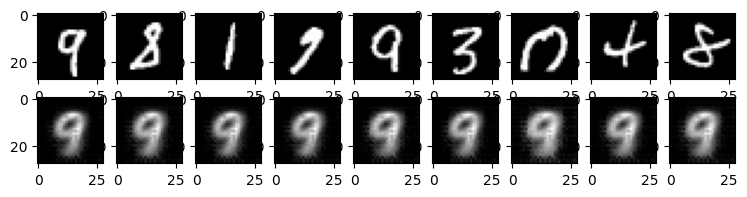

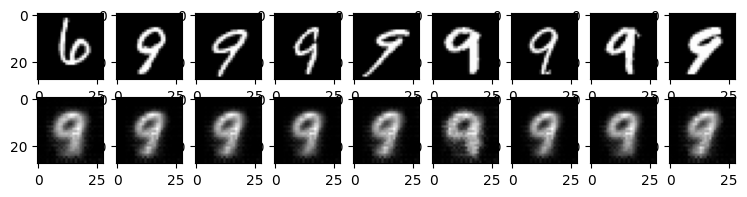

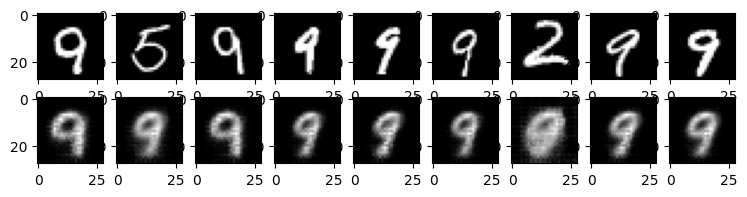

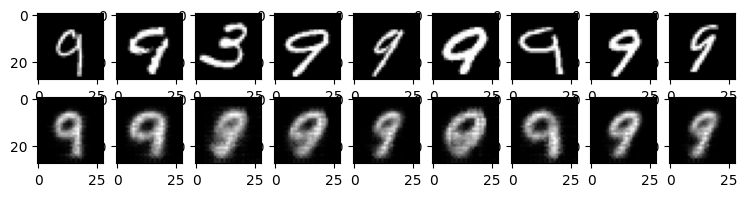

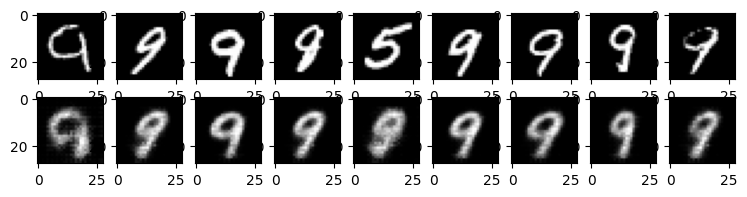

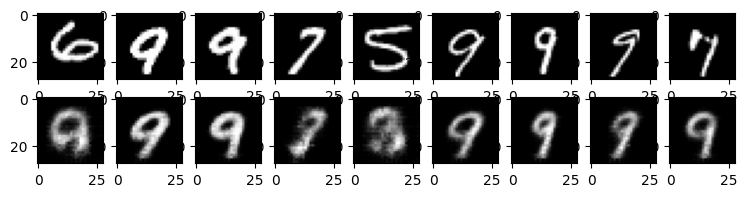

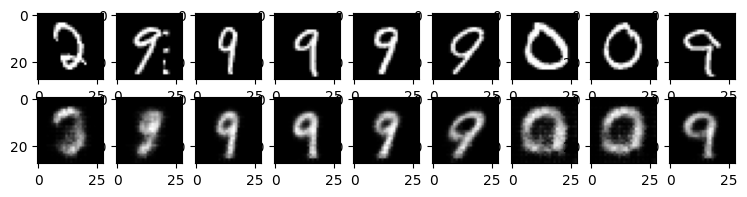

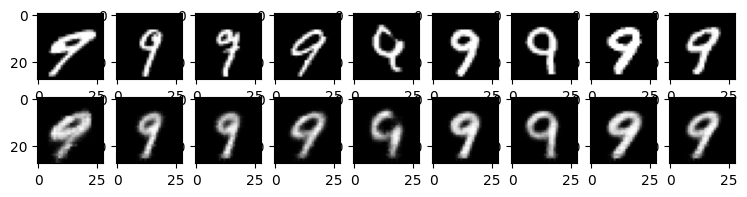

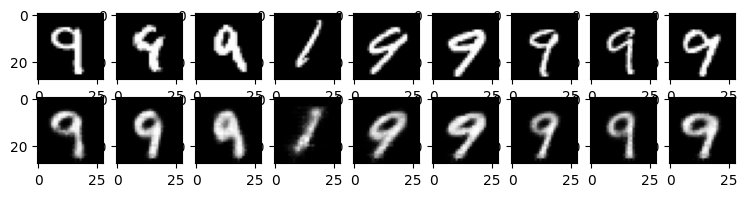

In [38]:
for k in range(0, num_epochs, 2):
    print("Epoch:",k)
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        # item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])
            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        # item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])



In [39]:

def calculate_losses(loader):
    normal = []
    anomalie = []
    for (img, label) in loader:
        loss = criterion(model(img), img)
        if label.item() == selected_label:
            normal.append(loss)
        else:
            anomalie.append(loss)
            
    normal.sort()
    anomalie.sort()

    normal = [round(tensor.tolist(),4) for tensor in normal]
    anomalie = [round(tensor.tolist(),4) for tensor in anomalie]
    return normal, anomalie

normal_train, anomalie_train = calculate_losses(train_loader_without_batch)
normal_test, anomalie_test = calculate_losses(test_loader)

print(normal_train)
print(anomalie_train)

min_loss = min((min(normal_train),min(anomalie_train)))
max_loss = max((max(normal_train),max(anomalie_train)))
print(min_loss, max_loss)

print()
print(normal_test)
print(anomalie_test)


[0.0053, 0.0054, 0.0055, 0.0057, 0.0057, 0.0058, 0.0059, 0.006, 0.006, 0.006, 0.006, 0.0061, 0.0062, 0.0062, 0.0062, 0.0062, 0.0063, 0.0063, 0.0063, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0065, 0.0065, 0.0065, 0.0065, 0.0065, 0.0065, 0.0066, 0.0066, 0.0066, 0.0066, 0.0067, 0.0067, 0.0067, 0.0067, 0.0067, 0.0068, 0.0068, 0.0069, 0.0069, 0.0069, 0.0069, 0.0069, 0.007, 0.007, 0.007, 0.007, 0.007, 0.007, 0.007, 0.007, 0.007, 0.007, 0.0071, 0.0071, 0.0071, 0.0071, 0.0071, 0.0071, 0.0071, 0.0071, 0.0072, 0.0072, 0.0072, 0.0072, 0.0072, 0.0072, 0.0072, 0.0072, 0.0073, 0.0073, 0.0073, 0.0073, 0.0073, 0.0073, 0.0073, 0.0074, 0.0074, 0.0074, 0.0074, 0.0074, 0.0074, 0.0074, 0.0074, 0.0074, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0076, 0.0076, 0.0076, 0.0076, 0.0076, 0.0076, 0.0076, 0.0076, 0.0076, 0.0077, 0.0077, 0.0077, 0.0077, 0.0077, 0.0077, 0.0077, 0.0078, 0.0078, 0.0078, 0.0078, 0.0078, 0.0078, 0.0078, 0.0078, 0.0078, 0.007

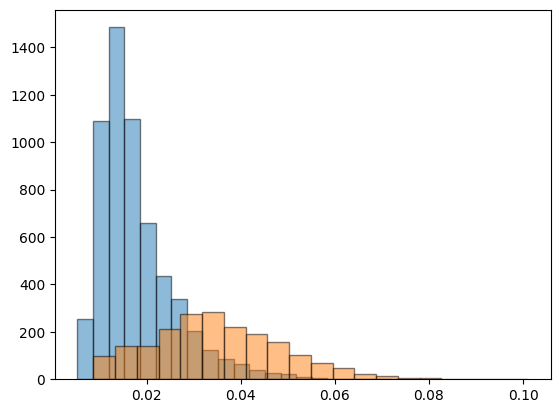

(array([ 302.,  662.,  518.,  740., 1011., 1138., 1113.,  963.,  823.,
         657.,  401.,  255.,  184.,  107.,   53.,   34.,   14.,   11.,
           2.,    3.]),
 array([0.008  , 0.01233, 0.01666, 0.02099, 0.02532, 0.02965, 0.03398,
        0.03831, 0.04264, 0.04697, 0.0513 , 0.05563, 0.05996, 0.06429,
        0.06862, 0.07295, 0.07728, 0.08161, 0.08594, 0.09027, 0.0946 ]),
 <BarContainer object of 20 artists>)

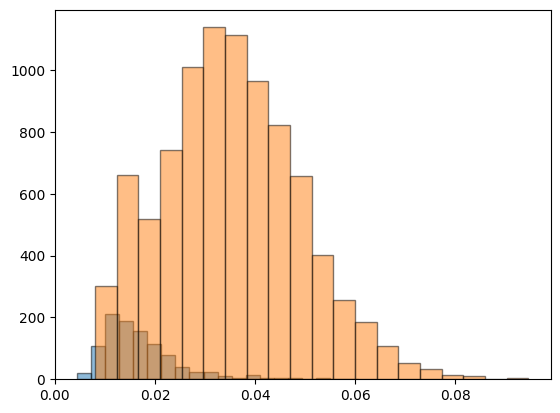

In [40]:
bins = 20
plt.hist(normal_train, alpha=0.5, bins=bins, label='Data 1', edgecolor='black')
plt.hist(anomalie_train, alpha=0.5, bins=bins, label='Data 2', edgecolor='black')

plt.show()

plt.hist(normal_test, alpha=0.5, bins=bins, label='Data 1', edgecolor='black')
plt.hist(anomalie_test, alpha=0.5, bins=bins, label='Data 2', edgecolor='black')

0.8638120612871198
0.8779354731892998


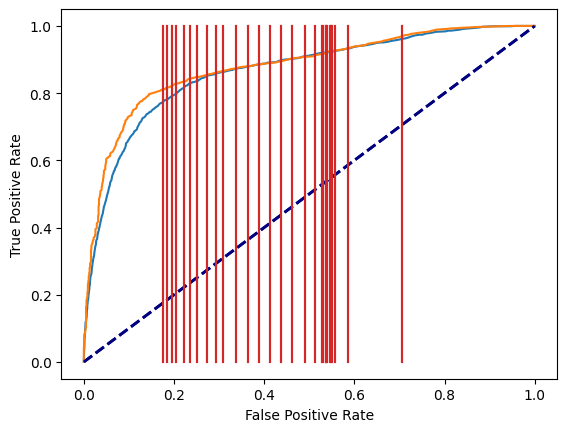

In [41]:
def display_roc(t,p):
    fpr, tpr, _ = sk.metrics.roc_curve(t, p)
    roc_auc = metrics.auc(fpr, tpr)

    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    for loss in losses:
        l = loss.item()
        
        # normalize
        l = (l-min_loss) / (max_loss - min_loss)
        
        if l <= 1:
            plt.plot([l,l],(0,1), linestyle='-', color="tab:red")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    print(roc_auc)
    
t = [0] * len(normal_train) + [1] * len(anomalie_train)
p = normal_train + anomalie_train
display_roc(t,p)

t = [0] * len(normal_test) + [1] * len(anomalie_test)
p = normal_test + anomalie_test
display_roc(t,p)